In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem
from molvecgen.vectorizers import SmilesVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas, numpy, random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# To make simpler model, we setup a baseline, when molecular's mu > baseline, we set it to 1, otherwise 0
baseline = 2.3

In [3]:
# dataset
class SMILESMolDataset(Dataset):
    def __init__(self, molecules, y, vectorizer):
        self.molecules = molecules
        self.y = y
        self.vectorizer = vectorizer
    def __len__(self):
        return len(self.molecules)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        mols = self.molecules[idx]
         
        #The vectorizer was written to work with batches, 
        #but PyTorch datasets unfortunately works with single samples
        sample = self.vectorizer.transform([mols])[0]
        label = float(self.y[idx] > baseline)
        #print("self.y[idx]", self.y[idx], 'label', label)

        target = torch.FloatTensor([label])
        
        return sample, label, target

,smiles,mu,alpha,homo,lumo,gap,r2,zpve,cv,u0,u298,h298,g298,Molecule
200,Cc1cc[nH]c1,1.6978,55.32,-0.1982,0.0533,0.2515,528.9258,0.109903,20.948,-249.395323,-249.389640,-249.388696,-249.424242,
201,Cc1c[nH]cn1,3.3147,51.32,-0.2157,0.0376,0.2533,500.6403,0.098598,19.536,-265.457424,-265.451994,-265.451050,-265.486153,
202,Cc1ccoc1,0.8398,51.11,-0.2183,0.0250,0.2434,512.5694,0.097541,19.399,-269.263476,-269.258130,-269.257186,-269.292093,

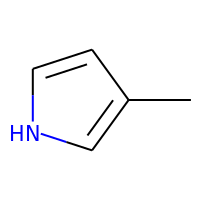
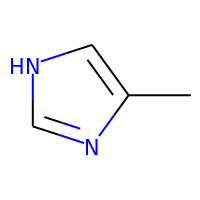
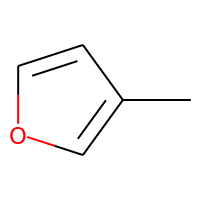

In [4]:
# read qm9.csv to get data
dataset = pandas.read_csv('dataset/qm9.csv',skiprows=lambda i: i % 2 != 0 and i == 0,nrows=6000)
PandasTools.AddMoleculeColumnToFrame(dataset,'smiles','Molecule')

smivec = SmilesVectorizer(pad=1, leftpad=True, canonical=False, augment=True)
smivec.fit(dataset.Molecule.values, )

dataset[200:203]

In [5]:
# x_data(SMILES/Molecule) is the data for Generator,but we don't use y_data, we will use random y;
# x_train, y_train are real examples, it will pass to Discriminator;
x_train, x_data, y_train, y_data = train_test_split(dataset[['smiles','Molecule']].values, dataset['mu'].values, test_size=0.5)
x_train = pd.DataFrame(x_train, columns=['smiles','Molecule'])
x_data = pd.DataFrame(x_data, columns=['smiles','Molecule'])

print('length of x_train:',len(x_train),'x_data',len(x_data),'y_train', len(y_train), 'y_data', len(y_data))


length of x_train: 3000 x_data 3000 y_train 3000 y_data 3000


In [6]:
# data statistics
max_mu = max(y_data)
min_mu = min(y_data)
number_of_data = len(y_data)

number1 = len(y_data[y_data > baseline])
number2 = len(y_data[y_data <= baseline])
print(' > baseline', number1, ' <= baseline', number2)
print("number_of_data", number_of_data, "max_mu", max_mu, "min_mu", min_mu)
#real_data.head(5)


#print(real_data['mu'])

 > baseline 1482  <= baseline 1518
number_of_data 3000 max_mu 14.6499 min_mu 0.0


In [7]:
# functions to generate random data
def generate_random_seed_G(size):
    random_data = torch.randn(size)
    return random_data


def generate_random_value(size):
    random_data = np.random.randint(0, baseline * 2,(1, size))
    random_data = torch.FloatTensor(random_data)
    return random_data.view(-1)

def generate_random_label(size):
    random_data = np.random.randint(0, 2,(1, size))
    random_data = torch.FloatTensor(random_data)
    return random_data.view(-1)


class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

print(generate_random_value(5))
print(generate_random_label(5))

tensor([1., 2., 2., 1., 2.])
tensor([1., 1., 0., 1., 0.])


In [8]:
# dataset for Generator, we 'Molecule' data will be used and actually ignore y_data in Generator, instead we use
# random value, but keeping it simple, we shape one SMILESMolDataset class.
data_dataset = SMILESMolDataset(x_data['Molecule'], y_data, smivec)
print('data_dataset[10]', data_dataset[10], 'y_data', y_data[10] )

data_dataset[10] (array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [9]:
# Real examples
train_dataset = SMILESMolDataset(x_train['Molecule'], y_train, smivec)
train_dataset[10]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
# return a random SMILES
def generate_random_seed(size):
    index_list = np.random.randint(1, number_of_data, (1, size))[0]
    random_data = []
    for i in index_list:
          random_data.append( data_dataset[i] )
    #random_data = data_dataset[10]
    return random_data

generate_random_seed(2)[0][1]

0.0

In [11]:
# Model setting
epochs = 16
dims = smivec.dims
batch_size = 1   # The mini_batch size during training
G_input_size = 100 # The Generator input data size
learning_rate_D = 0.00075  # The Discriminator initial learning rate for the optimizer 
learning_rate_G = 0.00075  # The Generator initial learning rate for the optimizer



In [12]:
# discriminator class
class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        length = dims[0] 
        number_tokens = dims[1] + 1  # add the label layer

        self.model = nn.Sequential(
            View(length * number_tokens),
            nn.Linear(length * number_tokens, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        
        self.loss_function = nn.MSELoss()

        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate_D)

        # monitor
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, input_tensor, label_tensor):
        x = torch.cat((input_tensor, label_tensor), -1)
        return self.model(x)
    
    
    def train(self, inputs, label_tensor, targets):
        outputs = self.forward(inputs, label_tensor)

        loss = self.loss_function(outputs, targets)

        # monitor
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    # the plot to check convergent
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [13]:
# load real examples
from torch.utils.data import DataLoader
data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True, num_workers=4,drop_last=True )



In [14]:
# set device to gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [15]:
%%time
# test discriminator can separate real data from random noise
D = Discriminator()
D.to(device)

for smiles,label, target in data_loader:
    # real examples
    target = target.view(1).to(device)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    D.train(smiles.to(device).float(), label, target)
    
    # noise data
    fake_input = []
    fake_label = []
    for item in generate_random_seed(batch_size):
        fake_input.append(item[0])
        fake_label.append(item[1])
    
    target = torch.FloatTensor(fake_label).to(device)
    fake_input = torch.FloatTensor(fake_input).to(device)
    fake_label = torch.FloatTensor(fake_label).to(device)
    fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
    D.train(fake_input, fake_label, target)
    
    pass

counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
CPU times: user 21.8 s, sys: 1.75 s, total: 23.6 s
Wall time: 24.5 s


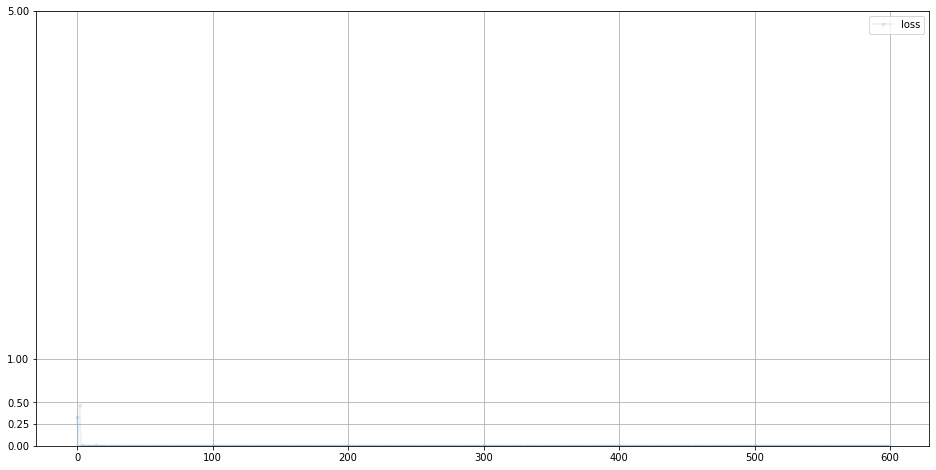

In [16]:
# check Discriminator progress and converge
D.plot_progress()

In [17]:
# unit test
i = 0
for smiles,label,target in data_loader:
    # real
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    result = D.forward(smiles.to(device).float(), label)
    print('label', label)
    print('result',result)
    
    
    i += 1
    if (i >= 1):
        break
    pass



label tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]], device='cuda:0')
result tensor([9.3862e-05], device='cuda:0', grad_fn=<SigmoidBackward>)


In [18]:
# unit test
fake_input = []
fake_label = []
for item in generate_random_seed(batch_size):
    fake_input.append(item[0])
    fake_label.append(item[1])
    
target = torch.FloatTensor(fake_label).view(1,len(fake_label),1).to(device)
fake_input = torch.FloatTensor(fake_input).to(device)
    
fake_label = torch.FloatTensor(fake_label).to(device)
fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
result = D.forward(fake_input, fake_label)
print('fake_label', fake_label)
print('result', result) 


fake_label tensor([[[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]], device='cuda:0')
result tensor([0.9996], device='cuda:0', grad_fn=<SigmoidBackward>)


In [19]:
# generator class

class Generator(nn.Module):
    
    def __init__(self, batch_size):
        super().__init__()
        
        self.batch_size = batch_size 
        self.model = nn.Sequential(
            nn.Linear(G_input_size * 2, 200),
            nn.LeakyReLU(0.02),
            #nn.LayerNorm(200),
            nn.Linear(200, number_of_data),
            nn.Sigmoid()

        )
        
        self.optimiser = torch.optim.Adam(self.parameters(), lr=learning_rate_G)
        
        # monitor
        self.counter = 0;
        self.progress = []
        self.stop = False
        
        pass
    
    
    def forward(self, seed_tensor, label_tensor):        
        # combine seed and label
        #print('Generator seed_tensor.shape', seed_tensor.shape, 'label_tensor', label_tensor.shape)
        inputs = torch.cat((seed_tensor, label_tensor))
        #print('after torch.cat', inputs.shape)
        outputs = self.model(inputs)
        #print('outputs', outputs)
        return torch.argmax(F.softmax(outputs, dim=0))


    def train(self, D, inputs, label_tensor, targets):
        g_output = self.forward(inputs, label_tensor.repeat(G_input_size))

        # get SMILES by g_output
        g_smiles, _, _ = data_dataset[g_output]
        
        # convert SMILES to tensor
        g_input = torch.FloatTensor(g_smiles).to(device)
        g_input = g_input.reshape(1, g_input.shape[0], g_input.shape[1])
        
        # convert label_tensor dimension
        g_label = label_tensor.repeat(1, g_input.shape[1], 1)
        
        # pass to discriminator
        d_output = D.forward(g_input, g_label)
        
        loss = D.loss_function(d_output, targets)

        # monitor
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        
        
        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    # a function to predict by label, return one SMILES
    def get_smiles(self, label):
        label_tensor = torch.zeros((G_input_size))
        for i in range(G_input_size):
            label_tensor[i] = label
    
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(label_tensor).to(device)
        idx = G.forward(fake_input, fake_label).detach().cpu().numpy()
        return x_data['smiles'].iloc[idx]

    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [20]:
# check the generator output is of the right type and shape
G = Generator(1)
G.to(device)

fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
idx = G.forward(fake_input, fake_label)
print('idx', idx)
data_dataset[idx]


idx tensor(1189, device='cuda:0')


(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0],
        [0, 0, 0, 0, 0, 0, 0, 0,

In [21]:
G.get_smiles(1.0)

'CCn1cccn1'

In [22]:
%%time

# train Discriminator and Generator
D = Discriminator()
D.to(device)
G = Generator(batch_size)
G.to(device)


for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
    for smiles,label,target in data_loader:
        # train discriminator on true
        target = torch.FloatTensor(torch.ones(smiles.shape[0])).to(device)
        label = label.float().to(device)
        label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
        D.train(smiles.to(device).float(), label, target)

        # train discriminator on false
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(generate_random_label(1)).to(device)
        idx = G.forward(fake_input, fake_label.repeat(G_input_size)).detach().cpu().numpy()
        g_smiles, _, _ = data_dataset[idx]

        g_input = torch.FloatTensor(g_smiles).to(device)
        g_input = g_input.reshape(1, g_input.shape[0], g_input.shape[1])
        g_label = fake_label.repeat(1, g_input.shape[1], 1)
        
        target = torch.FloatTensor(torch.zeros(len(fake_label))).to(device)
        D.train(g_input, g_label, target)
        
        # train generator
        fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
        fake_label = torch.FloatTensor(generate_random_label(1)).to(device)
        target = torch.FloatTensor([0.0]).to(device)
        G.train(D, fake_input, fake_label, target)
        
    pass
pass


epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
epoch =  2
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
epoch =  3
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
epoch =  4
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
epoch =  5
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
epoch =  6
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
epoch =  7
counter =  37000
counter =  38000
counter =  39000
counter =  40000
counter =  41000
counter =  42000
epoch =  8
counter =  43000
counter =  44000
counter =  45000
counter =  46000
counter =  47000
counter =  48000
epoch =  9
counter =  49000
counter =  50000
counter =  51000
counter =  52000
counter =  53000
counter =

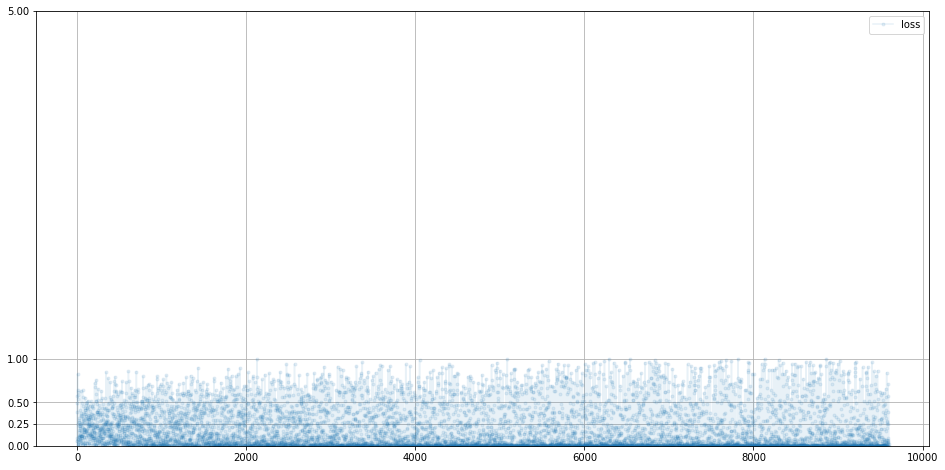

In [23]:
# check Discriminator progress and converge
D.plot_progress()

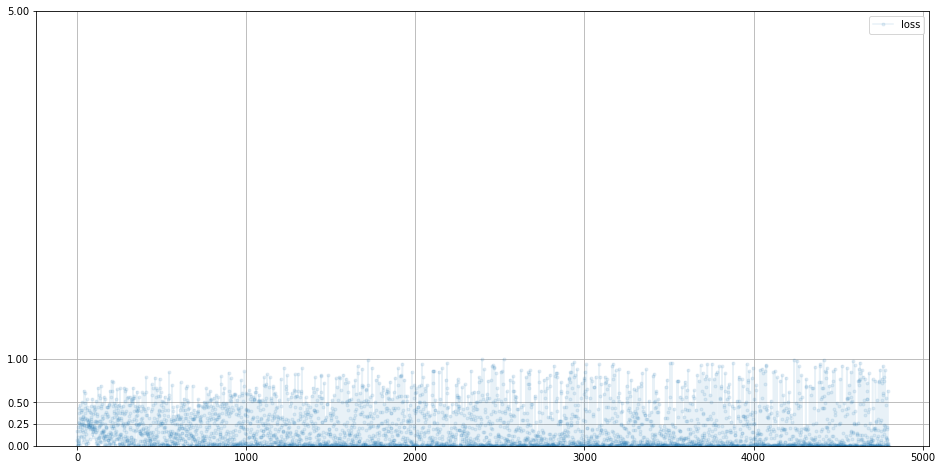

In [24]:
# test train result by getting a SMILES
G.plot_progress()

In [25]:
# a quick test the accuracy
qm9_dataset = pandas.read_csv('dataset/qm9.csv')
accuracy = []
number_of_verify = 100
for i in range(number_of_verify):
    test_smiles = G.get_smiles(1.0)
    real = qm9_dataset[qm9_dataset['smiles'] == test_smiles ]
    #print('Test Result:', real.iat[0,0],real.iat[0,1], real.iat[0,1] > baseline)
    accuracy.append(real.iat[0,1] > baseline)
np.mean(accuracy)

0.88

In [26]:
# more test: Discriminator test by real examples
i = 0
for smiles,label,target in data_loader:
    # real
    target = torch.FloatTensor([1.0]).view(1,1,1).repeat(1, smiles.shape[0] ,1).to(device)
    label = label.float().to(device)
    label = label.view(batch_size, 1, 1).repeat(1, smiles.shape[1], 1)
    
    print(D.forward(smiles.to(device).float(), label))
    
    i += 1
    if (i >= 10):
        break
    pass



tensor([0.5538], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8333], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8233], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8408], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.7605], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.9148], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8669], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.7647], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8294], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.5353], device='cuda:0', grad_fn=<SigmoidBackward>)


In [27]:
# more test: Discriminator test by random data
for i in range(10):
    fake_input = []
    fake_label = []
    for item in generate_random_seed(batch_size):
        fake_input.append(item[0])
        fake_label.append(item[1])
    
    fake_input = torch.FloatTensor(fake_input).to(device)
    fake_label = torch.FloatTensor(fake_label).to(device)
    fake_label = fake_label.view(batch_size, 1, 1).repeat(1, fake_input.shape[1], 1)
    target = torch.FloatTensor([0.0]).view(1,1,1).repeat(1, fake_input.shape[0] ,1).to(device)
    print(D.forward(fake_input, fake_label))
    pass


tensor([0.7829], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.9551], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8077], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.7414], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8408], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.6839], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.7658], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.8469], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.9652], device='cuda:0', grad_fn=<SigmoidBackward>)
tensor([0.5139], device='cuda:0', grad_fn=<SigmoidBackward>)


In [28]:
# more test: generate SMILES
fake_input = torch.FloatTensor(generate_random_seed_G(G_input_size)).to(device)
fake_label = torch.FloatTensor(generate_random_value(G_input_size)).to(device)
result = G.forward(fake_input, fake_label).detach()
idx = result.cpu().numpy()
print('result', result, 'idx', idx, 'fake_input', fake_input.shape, 'fake_label.shape', fake_label.shape,  'result.shape', result.shape)
print(x_data['smiles'].iloc[idx])

result tensor(437, device='cuda:0') idx 437 fake_input torch.Size([100]) fake_label.shape torch.Size([100]) result.shape torch.Size([])
CC1(O)C2COC12


In [75]:
# save models
import pickle
from datetime import datetime

now = datetime.now() 
date_time = now.strftime("%Y%m%d%H%M")
G_filename = 'pre_train_model/GAN19G' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(G, open(G_filename, 'wb'))

D_filename = 'pre_train_model/GAN19D' + date_time + '.sav'
print('save model to file:', D_filename)
pickle.dump(D, open(D_filename, 'wb'))



save model to file: pre_train_model/GAN19G202104182315.sav
save model to file: pre_train_model/GAN19D202104182315.sav


In [31]:
#load models
'''
import pickle

Pkl_Filename = 'GAN19D202104150951.sav'
with open(Pkl_Filename, 'rb') as file:  
    D = pickle.load(file)
    
    
Pkl_Filename = 'GAN19G202104150951.sav'
with open(Pkl_Filename, 'rb') as file:  
    G = pickle.load(file)    
'''

"\nimport pickle\n\nPkl_Filename = 'GAN19D202104150951.sav'\nwith open(Pkl_Filename, 'rb') as file:  \n    D = pickle.load(file)\n    \n    \nPkl_Filename = 'GAN19G202104150951.sav'\nwith open(Pkl_Filename, 'rb') as file:  \n    G = pickle.load(file)    \n"

In [67]:
# metrics function
from sklearn.metrics import *

def classification_metrics(Y_pred, Y_true, Y_auc_true, Y_auc_pred):
    acc = accuracy_score(Y_true, Y_pred)
    auc_ = roc_auc_score(Y_auc_true, Y_auc_pred)
    
    precision = precision_score(Y_true, Y_pred, average='weighted')
    recall = recall_score(Y_true, Y_pred, average='weighted')
    f1score = f1_score(Y_true, Y_pred, average='weighted')
    return acc, auc_, precision, recall, f1score



In [68]:
qm9_dataset = pandas.read_csv('dataset/qm9.csv')

In [73]:
# calculate metrics
y_true = []
prodict = []
y_auc_true = []
y_auc_prodict = []
number_of_verify = 100
for i in range(number_of_verify):
    test_smiles = G.get_smiles(1.0)
    real = qm9_dataset[qm9_dataset['smiles'] == test_smiles ]
    #print('Test Result:', real.iat[0,0],real.iat[0,1], real.iat[0,1] > baseline)
    y_true.append(float(real.iat[0,1] > baseline))
    prodict.append(1.0)
    y_auc_true.append(float(real.iat[0,1] > baseline))
    y_auc_prodict.append(1.0)

# Fix auc issue
y_auc_true.append(0.0)
y_auc_prodict.append(0.0)
    
    
acc, auc_, precision, recall, f1score = classification_metrics(y_true, prodict, y_auc_true, y_auc_prodict)
print('acc', acc)
print('auc_', auc_)
print('precision', precision)
print('recall', recall)
print('f1score', f1score)


acc 0.82
auc_ 0.5263157894736843
precision 1.0
recall 0.82
f1score 0.9010989010989011


/home/tony/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
# get model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(D)
print("Total parameters of D", count_parameters(D))

print(G)
print("Total parameters of G", count_parameters(G))

Discriminator(
  (model): Sequential(
    (0): View()
    (1): Linear(in_features=600, out_features=200, bias=True)
    (2): LeakyReLU(negative_slope=0.02)
    (3): LayerNorm((200,), eps=1e-05, elementwise_affine=True)
    (4): Linear(in_features=200, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (loss_function): MSELoss()
)
Total parameters of D 120801
Generator(
  (model): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): LeakyReLU(negative_slope=0.02)
    (2): Linear(in_features=200, out_features=3000, bias=True)
    (3): Sigmoid()
  )
)
Total parameters of G 643200
